#BERT  - Fine-tuning a Text Classifier
we are going to apply the fine-tuning approach to use BERT to train a text classifier to get bitcoin comments sentiment score.

#1. Set Up
First, let's make sure GPU is available.

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2060


In [2]:
#!pip install transformers

#2. Download and Prepare Data
First, get the data ready. We'll use data from bitcoinTalk and reddit forum data


In [3]:
#!pip install wget

In [3]:
import wget
import os

We'll use in_domain_train.tsv in the "raw" folder.
0=unacceptable, 1=acceptable

In [6]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("tweet_sentiment.csv", header=0, names=['cleaned_tweets', 'sentiment'])

# remove the neutral sentiment 
df = df[df["sentiment"]!=0]

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display the first 10 rows from the data.
df.head(10)

Number of training sentences: 11,110



,cleaned_tweets,sentiment
2,say american dream dead,-1
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,-1
8,senat want emerg alert go netflix spotifi etc,1
10,u propos expedit appeal fight amp time warner ...,-1
14,custom urg boycott mgm resort casino file laws...,-1
20,trump tell cb alway want interview special cou...,1
23,ebay revenu miss weak u sport season hit stubhub,-1
25,rt exclus elon musk call sierra club execut di...,1
26,new time janet yellen convers brook feb pm est...,1


In [7]:
df = df.replace(-1,0)

In [8]:
# Display 10 random rows from the data.
df.sample(10)

,cleaned_tweets,sentiment
13518,ice intercontinent exchang inc email alert ser...,1
9463,weyerhaeus compani wy stock valu rose sharehol...,0
22076,current iota price verifi binanc accept new user,1
21517,rt think disney end fox reason disney like pre...,1
27310,ibm transcript incom expand pretax margin poin...,1
15682,top money flow today free stock app lqd nflx c...,1
17780,top coin last one hour motocoin moto fidentiax...,1
24003,raytheon co com new rtn valuat declin piedmont...,1
17336,bot detect coin list faster offici announc joi...,1
3759,us bancorp de decreas emerson electr co emr ho...,1


In [9]:
print("No. of positive sentences: ", len(df.loc[df.sentiment == 1]))
print("No. of negative sentences: ", len(df.loc[df.sentiment == 0]))
print("ratio of ones: ", len(df.loc[df.sentiment == 1])/len(df))

#let's sample a few more unacceptable sentences
df.loc[df.sentiment == 0].sample(5)[['cleaned_tweets', 'sentiment']]

No. of positive sentences:  8512
No. of negative sentences:  2598
ratio of ones:  0.7661566156615661


,cleaned_tweets,sentiment
25468,cm max pain matur maxpain option,0
670,investor buy ross store rost weak,0
24877,new post fine idea chip go straight hell amd c...,0
22012,emr work th straight monthli low set low risk ...,0
5211,insid die intl vuzi kopn himx eman,0


In [10]:
# Get the lists of sentences and their labels.
sentences = df.cleaned_tweets.values
labels = df.sentiment.values

#3. Encoding the data for BERT
Instead of using the manual coding, we will make use encode_plus(), a wonderful function from Bert Tokenizer in Transformers

In [14]:
import torch
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [12]:
print(tokenizer.encode("This is my dog."))

[101, 2023, 2003, 2026, 3899, 1012, 102]


In [13]:
print(tokenizer.encode_plus("This is my dog.", max_length = 15, padding = 'max_length'))

{'input_ids': [101, 2023, 2003, 2026, 3899, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]}


To set the max_length with a reasonable number, let's find out how long our longest sentence is in the dataset.

In [14]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (3478 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  4489


In [1]:
# since the max_length in tokenize.encode_plus is 512 and given comments usually are much less than 4489, we at first set the max_length
# as 512, however cuda will be out of memory and in practive 64 is enough.
# so we set the max_length = 64

In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]' default is True
                        max_length = 64,   # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)



In [16]:
print(labels.shape)

torch.Size([11110])


In [17]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Attention masks:', attention_masks[0])

Original:  say american dream dead
Token IDs: tensor([ 101, 2360, 2137, 3959, 2757,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#Split Dataset for Training and Validation
Let's get 90% for training and 10% for validation

In [20]:
from torch.utils.data import TensorDataset, random_split

In [18]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,999 training samples
1,111 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [19]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#4. Create the classification model
We use the task-specific BERT class for sequence classification, which is BERT + 1 linear layer for classification.

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

And define the optimizer and learning rate scheduler.

In [16]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [22]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

626


In [17]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#Train the model!

In [25]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()



In [26]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


# For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += outputs.loss.item()

        # Perform a backward pass to calculate the gradients.
        outputs.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += outputs.loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))       


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:14.
  Batch    80  of    313.    Elapsed: 0:00:27.
  Batch   120  of    313.    Elapsed: 0:00:40.
  Batch   160  of    313.    Elapsed: 0:00:53.
  Batch   200  of    313.    Elapsed: 0:01:07.
  Batch   240  of    313.    Elapsed: 0:01:20.
  Batch   280  of    313.    Elapsed: 0:01:34.

  Average training loss: 0.20
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.06
  Validation took: 0:00:04

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:13.
  Batch    80  of    313.    Elapsed: 0:00:27.
  Batch   120  of    313.    Elapsed: 0:00:40.
  Batch   160  of    313.    Elapsed: 0:00:54.
  Batch   200  of    313.    Elapsed: 0:01:07.
  Batch   240  of    313.    Elapsed: 0:01:21.
  Batch   280  of    313.    Elapsed: 0:01:34.

  Average training loss: 0.05
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.99
 

In [27]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.1966099628357413,
  'Valid. Loss': 0.06034883533471397,
  'Valid. Accur.': 0.9800077639751553,
  'Training Time': '0:01:45',
  'Validation Time': '0:00:04'},
 {'epoch': 2,
  'Training Loss': 0.04815863852817625,
  'Valid. Loss': 0.04814107697457075,
  'Valid. Accur.': 0.9871506211180124,
  'Training Time': '0:01:45',
  'Validation Time': '0:00:04'}]

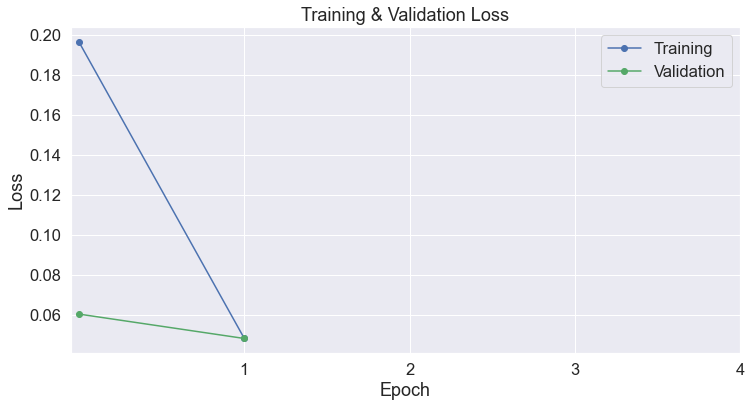

In [28]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#Test our model on test set
The test set needs to be prepared in the same way as the training set.

In [38]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_test = pd.read_csv("all-data.csv", 
                 header=None, names=['label', 'sentence'])

In [203]:
reddit_1 = pd.read_csv("..\\reddit-posts(1)\\reddit_post_texts-part3of3(1).csv", 
                 header=0,  usecols=[0, 4] )

In [204]:
reddit_1.head()

,date,update_text
0,07/11/2019,"[Daily Discussion] Thursday, November 07, 2019..."
1,07/11/2019,Long time DCA savers. Every day it clicks for ...
2,07/11/2019,What makes the buying pressure constant? Unles...
3,07/11/2019,More news out of China; World Blockchain Confe...
4,07/11/2019,BTC will become a global anchor for the digita...


In [39]:
df_test = df_test[df_test["label"]!="neutral"]

In [40]:
df_test = df_test.replace("negative",0)

In [41]:
df_test = df_test.replace("positive",1)

In [42]:
df_test.head()

,label,sentence
2,0,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...
5,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,1,"For the last quarter of 2010 , Componenta 's n..."


In [43]:
df_test.shape

(1967, 2)

In [44]:
print("No. of positive sentences: ", len(df_test.loc[df_test.label == 1]))
print("No. of negative sentences: ", len(df_test.loc[df_test.label == 0]))
print("ratio of ones: ", len(df_test.loc[df_test.label == 1])/len(df_test))

#let's sample a few more unacceptable sentences
df_test.loc[df_test.label == 1].sample(5)[['sentence', 'label']]

No. of positive sentences:  1363
No. of negative sentences:  604
ratio of ones:  0.6929334011184545


,sentence,label
34,The fair value of the property portfolio doubl...,1
1479,`` The CHF is a great product .,1
26,Nordea Group 's operating profit increased in ...,1
811,Lule+_ municipality has awarded YIT a 2-year c...,1
1690,VDW combined with LXE devices enhances product...,1


In [45]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
sentences_test = df_test.sentence.values
labels_test = df_test.label.values

Number of test sentences: 1,967



In [205]:
print('Number of test sentences: {:,}\n'.format(reddit_1.shape[0]))

Number of test sentences: 53,449



In [206]:
reddit_sentence = reddit_1.update_text

In [207]:
reddit_sentence.shape

(53449,)

In [208]:
reddit_sentence = reddit_sentence.replace(np.nan,"")

In [178]:
labels_test = reddit_1.date

In [46]:
sentences_test.shape

(1967,)

In [47]:
labels_test.shape

(1967,)

In [48]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [36]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

e:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [49]:
# Set the batch size.  
batch_size = 32

In [52]:
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, batch_size=batch_size)

In [53]:
input_ids.shape

torch.Size([1967, 64])

In [54]:
encoded_dict['input_ids'].shape

torch.Size([1, 64])

In [66]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    #b_input_ids, b_input_mask，b_labels= batch
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,967 test sentences...
    DONE.


In [67]:
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[-2.5112,  1.8757],
        [-3.4506,  2.9602],
        [-2.9990,  2.6263],
        [ 1.0842, -1.5430],
        [ 1.8417, -2.5324],
        [-1.7915,  1.2191],
        [-2.5817,  2.0223],
        [ 1.0309, -1.5172],
        [-1.8651,  1.4400],
        [-2.1217,  1.5776],
        [ 1.2080, -1.6583],
        [ 2.4027, -2.9051],
        [-2.9042,  2.3191],
        [-1.1318,  0.6328],
        [ 1.1615, -1.5953]], device='cuda:0'), hidden_states=None, attentions=None)


In [68]:
logits

array([[-2.51122   ,  1.8757458 ],
       [-3.4505732 ,  2.9602132 ],
       [-2.9989665 ,  2.626262  ],
       [ 1.0841652 , -1.5430192 ],
       [ 1.8416833 , -2.5324376 ],
       [-1.7914981 ,  1.2191113 ],
       [-2.5816529 ,  2.0222757 ],
       [ 1.0309373 , -1.5171888 ],
       [-1.8651229 ,  1.4399985 ],
       [-2.12174   ,  1.5776452 ],
       [ 1.2080251 , -1.6582628 ],
       [ 2.4027157 , -2.9050632 ],
       [-2.9041514 ,  2.3191364 ],
       [-1.1317978 ,  0.63281345],
       [ 1.1615164 , -1.595288  ]], dtype=float32)

In [69]:
label_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [218]:
len(predictions[0])

32

In [219]:
len(predictions)

1671

In [71]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [72]:
total_test_accuracy = 0
i = 0
score = []
for p, t in zip(predictions, true_labels):
    i = i+1
    print("Accuracy for batch %d : %f " %( i, flat_accuracy(p, t)))
    total_test_accuracy += flat_accuracy(p, t)
    for ind in p:
        score.append(softmax(ind))
        
print("Overall accuracy for test set:", total_test_accuracy/len(predictions))

Accuracy for batch 1 : 1.000000 
Accuracy for batch 2 : 0.937500 
Accuracy for batch 3 : 0.937500 
Accuracy for batch 4 : 0.968750 
Accuracy for batch 5 : 1.000000 
Accuracy for batch 6 : 0.937500 
Accuracy for batch 7 : 1.000000 
Accuracy for batch 8 : 0.968750 
Accuracy for batch 9 : 0.937500 
Accuracy for batch 10 : 0.906250 
Accuracy for batch 11 : 0.937500 
Accuracy for batch 12 : 0.656250 
Accuracy for batch 13 : 0.875000 
Accuracy for batch 14 : 0.968750 
Accuracy for batch 15 : 0.968750 
Accuracy for batch 16 : 0.218750 
Accuracy for batch 17 : 0.750000 
Accuracy for batch 18 : 0.812500 
Accuracy for batch 19 : 0.906250 
Accuracy for batch 20 : 0.937500 
Accuracy for batch 21 : 0.937500 
Accuracy for batch 22 : 1.000000 
Accuracy for batch 23 : 0.906250 
Accuracy for batch 24 : 0.906250 
Accuracy for batch 25 : 0.937500 
Accuracy for batch 26 : 0.968750 
Accuracy for batch 27 : 0.937500 
Accuracy for batch 28 : 0.906250 
Accuracy for batch 29 : 0.906250 
Accuracy for batch 30 :

In [70]:
total_test_accuracy = 0
for p, t in zip(predictions, true_labels):
  print("Accuracy for batch: ", flat_accuracy(p, t))
  total_test_accuracy += flat_accuracy(p, t)

print("Overall accuracy for test set:", total_test_accuracy/len(predictions))

Accuracy for batch:  1.0
Accuracy for batch:  0.9375
Accuracy for batch:  0.9375
Accuracy for batch:  0.96875
Accuracy for batch:  1.0
Accuracy for batch:  0.9375
Accuracy for batch:  1.0
Accuracy for batch:  0.96875
Accuracy for batch:  0.9375
Accuracy for batch:  0.90625
Accuracy for batch:  0.9375
Accuracy for batch:  0.65625
Accuracy for batch:  0.875
Accuracy for batch:  0.96875
Accuracy for batch:  0.96875
Accuracy for batch:  0.21875
Accuracy for batch:  0.75
Accuracy for batch:  0.8125
Accuracy for batch:  0.90625
Accuracy for batch:  0.9375
Accuracy for batch:  0.9375
Accuracy for batch:  1.0
Accuracy for batch:  0.90625
Accuracy for batch:  0.90625
Accuracy for batch:  0.9375
Accuracy for batch:  0.96875
Accuracy for batch:  0.9375
Accuracy for batch:  0.90625
Accuracy for batch:  0.90625
Accuracy for batch:  0.875
Accuracy for batch:  1.0
Accuracy for batch:  0.96875
Accuracy for batch:  1.0
Accuracy for batch:  0.75
Accuracy for batch:  0.84375
Accuracy for batch:  0.90625


In [220]:
total_test_accuracy = 0
i = 0
score = []
for p in predictions:
    for ind in p:
        score.append(softmax(ind))
        

In [221]:
len(score)

53449

In [167]:
def score_sentiment(score):
    sentiment_score = []
    for s in score:
        if(s[0]>s[1]):
            sentiment_score.append(-s[0])
        else:
            sentiment_score.append(s[1])
    return sentiment_score

In [222]:
sentiment_score = score_sentiment(score)

In [223]:
len(sentiment_score)

53449

In [224]:
scoreframe=pd.DataFrame(sentiment_score, columns=['sentiment_score']) 

In [225]:
scoreframe["date"] = reddit_1.date

In [227]:
scoreframe.to_csv("reddit_part3_sentiment_score.csv")

In [110]:
predictions[0]

array([[ 2.001637  , -2.5401917 ],
       [-1.788508  ,  1.1365982 ],
       [-2.3415625 ,  2.1074939 ],
       [-2.968067  ,  2.336479  ],
       [-1.1660908 ,  0.7669128 ],
       [-2.9805996 ,  2.4480143 ],
       [-3.0945036 ,  2.5572252 ],
       [-2.6709483 ,  2.0382955 ],
       [-2.6499603 ,  2.012151  ],
       [-3.3333914 ,  2.843562  ],
       [-2.7937586 ,  2.1665452 ],
       [-3.3497806 ,  2.7018323 ],
       [-3.0793748 ,  2.402466  ],
       [-2.1751997 ,  1.6461618 ],
       [-2.9301376 ,  2.354785  ],
       [-3.1320662 ,  2.6465302 ],
       [-2.529226  ,  2.0979555 ],
       [-3.0467997 ,  2.6193566 ],
       [-2.8391826 ,  2.1781101 ],
       [-2.046674  ,  1.5420882 ],
       [-2.4662054 ,  1.999744  ],
       [-2.684733  ,  2.0282543 ],
       [-3.2135668 ,  2.5374768 ],
       [-2.9920485 ,  2.4282563 ],
       [-2.5571969 ,  1.9922849 ],
       [-2.9574587 ,  2.313956  ],
       [-3.0091412 ,  2.3802555 ],
       [-2.965896  ,  2.309169  ],
       [-2.9108288 ,

In [109]:
score[0]

array([0.98945844, 0.0105416 ], dtype=float32)

In [111]:
softmax([ 2.001637  , -2.5401917 ])

array([0.9894584, 0.0105416])

In [39]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.label.sum(), len(df_test.label), (df_test.label.sum() / len(df_test.label) * 100.0)))

Positive samples: 1363 of 1967 (69.29%)


In [40]:
for t in true_labels:
  print('Positive samples in batch: %d of %d (%.2f%%)' % (t.sum(), len(t), (t.sum() / len(t) * 100.0)))

Positive samples in batch: 31 of 32 (96.88%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 29 of 32 (90.62%)
Positive samples in batch: 27 of 32 (84.38%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 10 of 32 (31.25%)
Positive samples in batch: 25 of 32 (78.12%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (100.00%)
Positive samples in batch: 32 of 32 (10

The dataset is imbalanced. A better way to measure performance is "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC), which ranges from -1 to 1.

In [41]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
pred_labels = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch, convert the predicted logits to 0/1 labels...
for i in range(len(predictions)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())
  

# For each input batch...
for i in range(len(true_labels)):

  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels[i])                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


e:\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
e:\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
e:\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
e:\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
e:\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
e:\anaconda3\envs\pytorch\lib\site-packa

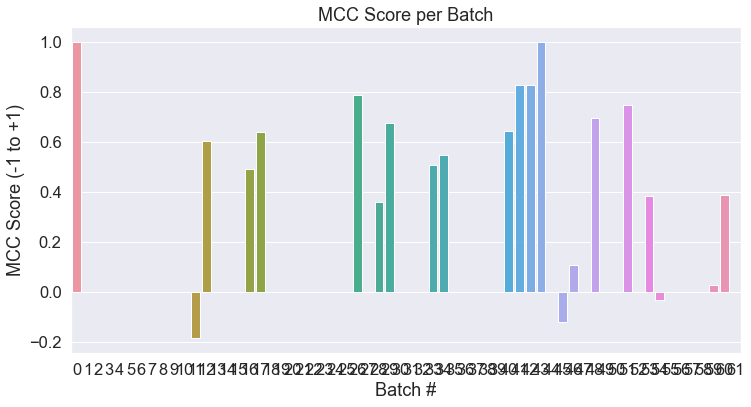

In [42]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [43]:
pred_labels[7]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [44]:
true_labels[7]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [45]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_pred_labels = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_pred_labels)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.577


In [64]:
#Saving your model.
output_file = ".model_bert_ft_bitcoin.pth"

In [137]:
def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_file)

save(model, optimizer)

In [65]:
#In the future, if you want to continue to work on this model, you can load it back in.
checkpoint = torch.load(output_file, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#Reference
BERT Fine-Tuning Tutorial with PyTorch, By Chris McCormick and Nick Ryan 

The original post is [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/).
